In [0]:
import pystan
from scipy import stats as sts
import numpy as np
import matplotlib.pyplot as plt

## **Using the non-hierarchical model for the eczema dataset**

In [0]:
eczema_data = {
    'treatment': {
        'alpha': 1, #fixed prior hyperparameter
        'beta': 1,  #fixed prior hyperparameter
        'num_trials': 6, 
        'patients': [23, 16, 16, 45, 31, 10],  
        'improved': [20, 10, 13, 35, 22, 7]}, 
    'control': {
        'alpha': 1, #fixed prior hyperparameter
        'beta': 1,  #fixed prior hyperparameter
        'num_trials': 6,
        'patients': [15, 18, 10, 39, 29, 10],
        'improved': [9, 11, 4, 21, 12, 0]}}


In [0]:
stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {  
    int<lower=1> num_trials;  // number of trials in the data set
    int<lower=0> patients[num_trials];  // number of patients per trial
    int<lower=0> improved[num_trials];  // number of improved patients per trial
    real<lower=0> alpha;  // fixed prior hyperparameter
    real<lower=0> beta;   // fixed prior hyperparameter
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    real<lower=0,upper=1> p;  // probability of improvement - the
                              // parameter of the binomial likelihood
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {
    p ~ beta(alpha, beta);  // prior over p
    for(i in 1:num_trials) {
        improved[i] ~ binomial(patients[i], p);  // likelihood function
    }
}

"""

In [4]:
stan_model = pystan.StanModel(model_code=stan_code)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4822bea325d0250e03828b3bc1bb8bdd NOW.


In [5]:
stan_results_control = stan_model.sampling(data=eczema_data['control']) # using the control group half
print(stan_results_control)

Inference for Stan model: anon_model_4822bea325d0250e03828b3bc1bb8bdd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p      0.47  1.2e-3   0.04   0.38   0.44   0.47    0.5   0.56   1419    1.0
lp__ -85.55    0.02   0.71 -87.59  -85.7 -85.28 -85.11 -85.06   1855    1.0

Samples were drawn using NUTS at Thu Apr  2 18:50:36 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


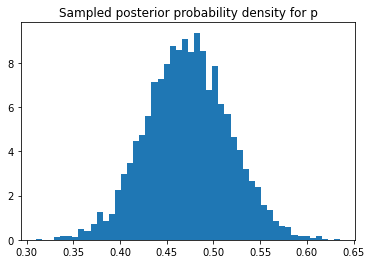

In [6]:
posterior_samples_control = stan_results_control.extract()
plt.hist(posterior_samples_control['p'], bins=50, density=True)
plt.title('Sampled posterior probability density for p')
plt.show()

## Generate new data by sampling from the posterior distribution
Calculate the test statistic for the replicated data (min value)

In [86]:
n_sample = 10000
control_sample = np.random.choice(posterior_samples_control['p'], size= n_sample) # sample p from the posterior distribution
num_patients = [15, 18, 10, 39, 29, 10] # number of patients in each medical trial

replicated_stat = []
for i in range(0, n_sample):
  replicated_data = []
  for t in range(len(num_patients)):
    replicated_array = sts.binom.rvs(num_patients[t], control_sample[i]) # draw number of improved patients for every trial from a binomial distribution
    replicated_data.append(replicated_array) # putting together list of improved patients for each p
  replicated_stat.append(np.amin(replicated_data)) # calculating the test statistic for every list and appending

print(replicated_stat)
print(np.mean(replicated_stat))

[4, 3, 6, 2, 2, 4, 4, 2, 1, 4, 3, 3, 4, 5, 4, 5, 4, 4, 4, 3, 2, 3, 3, 5, 2, 3, 5, 2, 5, 4, 7, 3, 4, 4, 5, 3, 5, 5, 3, 5, 3, 4, 3, 5, 3, 3, 4, 3, 2, 2, 6, 2, 3, 4, 5, 4, 5, 3, 0, 5, 2, 5, 6, 4, 4, 5, 5, 5, 4, 3, 2, 3, 4, 3, 2, 3, 2, 3, 5, 4, 2, 4, 3, 4, 3, 3, 4, 4, 3, 5, 4, 3, 5, 3, 3, 4, 4, 5, 4, 4, 2, 4, 4, 3, 5, 4, 7, 3, 3, 4, 6, 2, 3, 4, 3, 3, 3, 1, 3, 4, 3, 2, 5, 5, 5, 4, 5, 5, 2, 5, 2, 3, 2, 3, 4, 3, 4, 5, 2, 5, 2, 2, 5, 5, 4, 6, 3, 3, 4, 4, 2, 3, 3, 4, 5, 5, 2, 4, 4, 4, 4, 5, 4, 1, 1, 5, 3, 4, 4, 4, 1, 4, 5, 2, 3, 5, 6, 5, 6, 4, 4, 5, 4, 1, 3, 2, 3, 5, 3, 2, 4, 2, 3, 5, 6, 3, 5, 3, 5, 5, 2, 3, 5, 1, 3, 5, 5, 5, 5, 5, 5, 2, 6, 5, 1, 5, 3, 2, 4, 3, 5, 3, 3, 3, 3, 4, 3, 3, 4, 3, 2, 3, 4, 5, 4, 5, 4, 2, 3, 3, 3, 2, 4, 1, 1, 4, 4, 3, 4, 3, 6, 4, 6, 3, 4, 5, 6, 5, 4, 4, 5, 4, 1, 5, 6, 3, 3, 2, 6, 1, 5, 6, 4, 5, 6, 3, 3, 5, 3, 4, 3, 5, 2, 3, 5, 2, 5, 2, 4, 4, 3, 5, 3, 4, 3, 4, 4, 4, 4, 3, 2, 4, 2, 6, 3, 3, 1, 3, 3, 4, 4, 3, 2, 5, 6, 3, 4, 4, 6, 4, 4, 3, 5, 2, 2, 2, 2, 1, 2, 5, 5, 2, 4, 

In [47]:
# Compute test statistic on real data set
real_improved = [9, 11, 4, 21, 12, 0]
real_stat = np.amin(real_improved)

print(real_stat)

0


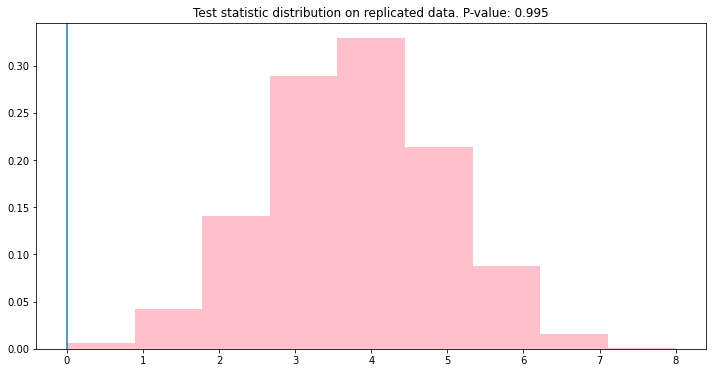

In [72]:
plt.figure(figsize=(12, 6))
plt.hist(replicated_stat, bins = 9, density=True, color='pink')
plt.axvline(real_stat)
plt.title('Test statistic distribution on replicated data. P-value: %.3f' % (
    np.mean(np.array(replicated_stat) > real_stat)))
plt.show()

## Interpretation of the model fit:
As we can see in the histogram above, the minimum values for the generated dataset are on average much higher than the minimum value for the original dataset. Using minimum value is a good way to test the fit of the model because it shows that our model is predicting more people in the control group to have recovered than actually did, for at least one of the trials This means the improvement rate is off. While the original dataset has 0 patients improved in the control group of one of the trials, the generated dataset has the minimum average at 3.75.

This is also clear when we use the maximum value as the test statistic (below) – although the p-value is not as extreme, it still shows that the values generated tend to be higher. While the maximum in the original dataset is 21 patients, the average maximum value in the generated dataset is 18.65.

[15, 16, 22, 15, 17, 21, 18, 19, 15, 24, 14, 18, 17, 18, 17, 17, 24, 21, 16, 17, 14, 15, 19, 20, 20, 20, 22, 21, 15, 18, 23, 13, 21, 18, 19, 13, 17, 13, 14, 19, 17, 23, 18, 20, 19, 17, 23, 20, 18, 19, 20, 18, 20, 21, 20, 18, 26, 17, 17, 18, 17, 24, 23, 19, 16, 19, 21, 22, 12, 20, 17, 22, 17, 15, 11, 17, 20, 23, 17, 16, 17, 18, 13, 17, 14, 20, 22, 19, 24, 16, 18, 21, 14, 16, 21, 22, 17, 23, 24, 17, 20, 15, 19, 16, 16, 18, 22, 20, 19, 14, 27, 24, 16, 16, 19, 20, 17, 14, 14, 20, 23, 13, 24, 22, 22, 20, 19, 16, 15, 20, 21, 21, 19, 25, 18, 19, 22, 18, 19, 19, 14, 22, 17, 18, 17, 22, 18, 24, 21, 20, 19, 15, 19, 15, 22, 22, 11, 19, 21, 21, 23, 20, 20, 16, 16, 16, 18, 20, 18, 19, 14, 22, 20, 18, 18, 21, 19, 21, 24, 21, 18, 19, 18, 16, 18, 13, 17, 18, 15, 15, 19, 19, 20, 18, 18, 20, 18, 20, 24, 17, 18, 16, 16, 17, 17, 20, 18, 22, 17, 22, 13, 12, 18, 26, 20, 19, 17, 17, 19, 17, 26, 21, 17, 20, 22, 22, 15, 18, 14, 14, 18, 17, 19, 20, 23, 24, 16, 19, 17, 17, 17, 14, 23, 16, 16, 16, 22, 18, 17, 23,

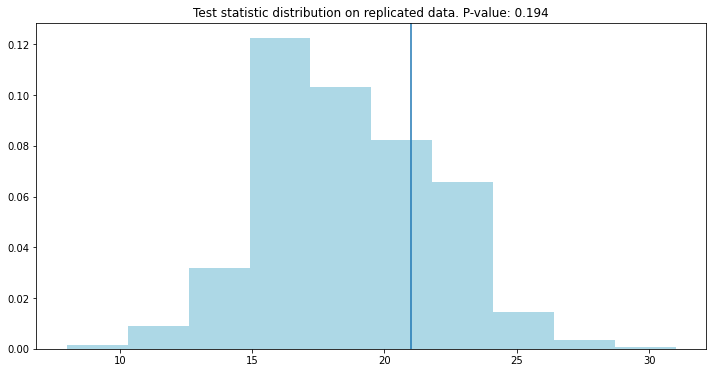

In [88]:
replicated_max = []
for i in range(0, n_sample):
  replicated_data1 = []
  for t in range(len(num_patients)):
    replicated_array1 = sts.binom.rvs(num_patients[t], control_sample[i]) # draw number of improved patients for every trial from a binomial distribution
    replicated_data1.append(replicated_array1) # putting together list of improved patients for each p
  replicated_max.append(np.amax(replicated_data1)) # calculating the test statistic for every list and appending
print(replicated_max)
print(np.mean(replicated_max))

real_amax = np.amax(real_improved)
print(real_amax)

plt.figure(figsize=(12, 6))
plt.hist(replicated_max, density=True, color='lightblue')
plt.axvline(real_amax)
plt.title('Test statistic distribution on replicated data. P-value: %.3f' % (
    np.mean(np.array(replicated_max) > real_amax)))
plt.show()